In [1]:
!pip install tensorboardcolab

In [2]:
import keras
import csv
import os
import itertools
import numpy as np
from keras.layers import *
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from google.colab import drive, files
from tensorboardcolab import *
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
TRAIN_DIR = r'/content/drive/My Drive/domain_adaptation_images/amazon/images'
VAL_DIR =  r'/content/drive/My Drive/domain_adaptation_images/dslr/images'
TEST_DIR =  r'/content/drive/My Drive/domain_adaptation_images/webcam/images'

In [0]:
img_width, img_height = 300, 300

In [0]:
batch_size = 16
epoch = 10
drop_prob = 0.5
out_class = 31

In [0]:
train_gen = ImageDataGenerator(rescale=1. / 255, zoom_range=0.2, horizontal_flip = True, vertical_flip = True)

In [0]:
test_gen = ImageDataGenerator(rescale=1. / 255)

In [9]:
train_generator = train_gen.flow_from_directory(TRAIN_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 2817 images belonging to 31 classes.


In [10]:
val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 498 images belonging to 31 classes.


In [11]:
test_generator = test_gen.flow_from_directory(TEST_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 795 images belonging to 31 classes.


In [12]:
input_ = Input(shape=(img_width, img_height, 3))
transfer_model = InceptionV3(input_tensor = input_, weights = 'imagenet', include_top = False)

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step


In [13]:
x = transfer_model.output

#x = MaxPooling2D()(x)

x = Flatten()(x)

x = Dropout(drop_prob)(x)

out = Dense(out_class, activation = 'softmax')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model(inputs = transfer_model.input, outputs = out)

In [0]:
adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [0]:
for layer in transfer_model.layers:
    layer.trainable = False

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam_, metrics = ['accuracy'])

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [19]:
tensorboard = TensorBoardColabCallback(TensorBoardColab()) #Using Tensorboard on google colab

Wait for 8 seconds...
TensorBoard link:
http://a804b8dd.ngrok.io


In [0]:
checkpointer = ModelCheckpoint(filepath='checkpoint_inception.h5', save_best_only=True)

In [0]:
callback_list = [tensorboard, checkpointer]

In [22]:
model.fit_generator(train_generator, steps_per_epoch = int(2817/batch_size), epochs = epoch, shuffle = True, 
                   validation_data = val_generator, validation_steps = int(498/batch_size), callbacks = callback_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
176/176 [==============================] - 771s 4s/step - loss: 2.1616 - acc: 0.5199 - val_loss: 1.4141 - val_acc: 0.6391
Epoch 2/10
176/176 [==============================] - 78s 446ms/step - loss: 1.1578 - acc: 0.7177 - val_loss: 1.5040 - val_acc: 0.6660
Epoch 3/10
176/176 [==============================] - 79s 447ms/step - loss: 0.9069 - acc: 0.7827 - val_loss: 1.4975 - val_acc: 0.6577
Epoch 4/10
176/176 [==============================] - 79s 449ms/step - loss: 0.6877 - acc: 0.8210 - val_loss: 1.3524 - val_acc: 0.6992
Epoch 5/10
176/176 [==============================] - 79s 450ms/step - loss: 0.6028 - acc: 0.8459 - val_loss: 1.3300 - val_acc: 0.6888
Epoch 6/10
176/176 [==============================] - 78s 446ms/step - loss: 0.5247 - acc: 0.8665 - val_loss: 1.2948 - val_acc: 0.7178
Epoch 7/10
176/176 [==============================] - 78s 441ms/step - loss: 0.5227 - acc: 0.8601 - val_loss: 1.6628 - val_acc: 0.6826
Epoch 8/1

In [0]:
Y_pred = model.predict_generator(test_generator, int(795/batch_size+1))
y_pred = np.argmax(Y_pred, axis=1)

In [0]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, int(795/batch_size+1))

In [25]:
test_loss

1.4913159303695152

In [26]:
test_accuracy

0.7194968552709375

In [0]:
model_check = load_model('checkpoint_inception.h5')

In [0]:
test_check_loss, test_check_acc = model_check.evaluate_generator(test_generator, int(795/batch_size+1))

In [30]:
test_check_loss

1.2922323375940323

In [31]:
test_check_acc

0.7220125784664034

In [0]:
target_names = ['Back pack', 'Bike', 'Bike Helmet', 'Bookcase', 'Bottle', 'Calculator', 'Desk chair', 'Desk lamp', 'Desktop computer', 'File cabinet', 
               'Headphones', 'Keyboard', 'Laptop', 'Letter tray', 'Mobile phone', 'Monitor', 'Mouse', 'Mug', 'Paper Notebook', 'Pen', 'Phone', 'Printer', 'Projector', 
               'Punchers', 'Ring binder', 'Ruler', 'Scissors', 'Speaker', 'Stapler', 'Tape dispenser', 'Trash can']

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()

In [0]:
cnf = confusion_matrix(test_generator.classes, y_pred)

Confusion matrix
[[1 0 0 0 0 0 0 0 1 0 2 3 3 2 0 1 2 1 2 0 0 3 1 3 2 0 0 0 0 2 0]
 [0 1 1 0 0 0 1 0 2 2 0 1 1 1 1 0 0 1 2 1 1 2 0 1 0 0 1 0 0 1 0]
 [0 1 1 1 0 0 0 2 2 0 0 1 0 0 1 3 1 1 2 2 2 0 3 2 0 0 1 1 0 0 1]
 [0 2 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 2 0 0 1 0 0 3 0 2 1 1 0 1 0 2 0 0 0 1]
 [0 0 1 1 0 1 2 1 1 1 2 1 0 3 0 0 1 2 0 1 0 3 1 3 2 0 1 0 2 1 0]
 [4 0 1 0 1 1 1 1 2 2 2 2 0 1 2 1 4 1 0 3 0 0 2 1 2 1 1 1 1 1 1]
 [0 1 0 0 0 0 3 2 1 1 0 0 1 0 0 1 0 0 1 0 2 0 0 0 2 0 1 0 1 0 1]
 [2 0 0 0 0 0 3 1 3 0 1 1 0 0 0 0 1 2 1 1 0 1 0 2 0 1 0 0 0 0 1]
 [1 1 2 1 0 2 0 0 1 2 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 1 2 1 0 0 2 1 2 0 0 1 1 2 1 0 2 0 2 0 2 3 1 0 1 1]
 [0 0 0 0 0 3 1 2 3 2 0 0 0 1 0 2 3 3 1 2 0 0 1 0 1 0 2 0 0 0 0]
 [1 0 0 0 0 1 0 1 1 0 4 4 4 0 0 1 0 2 1 1 2 1 2 1 0 2 0 1 0 0 0]
 [0 0 3 0 2 0 3 0 3 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 4 1 0 1 0 2 1 4 0 2 1 0 1 0 1 0 1 0 4 0 1 1 1 2 0 0 0 0 0 1]
 [3 1 0 

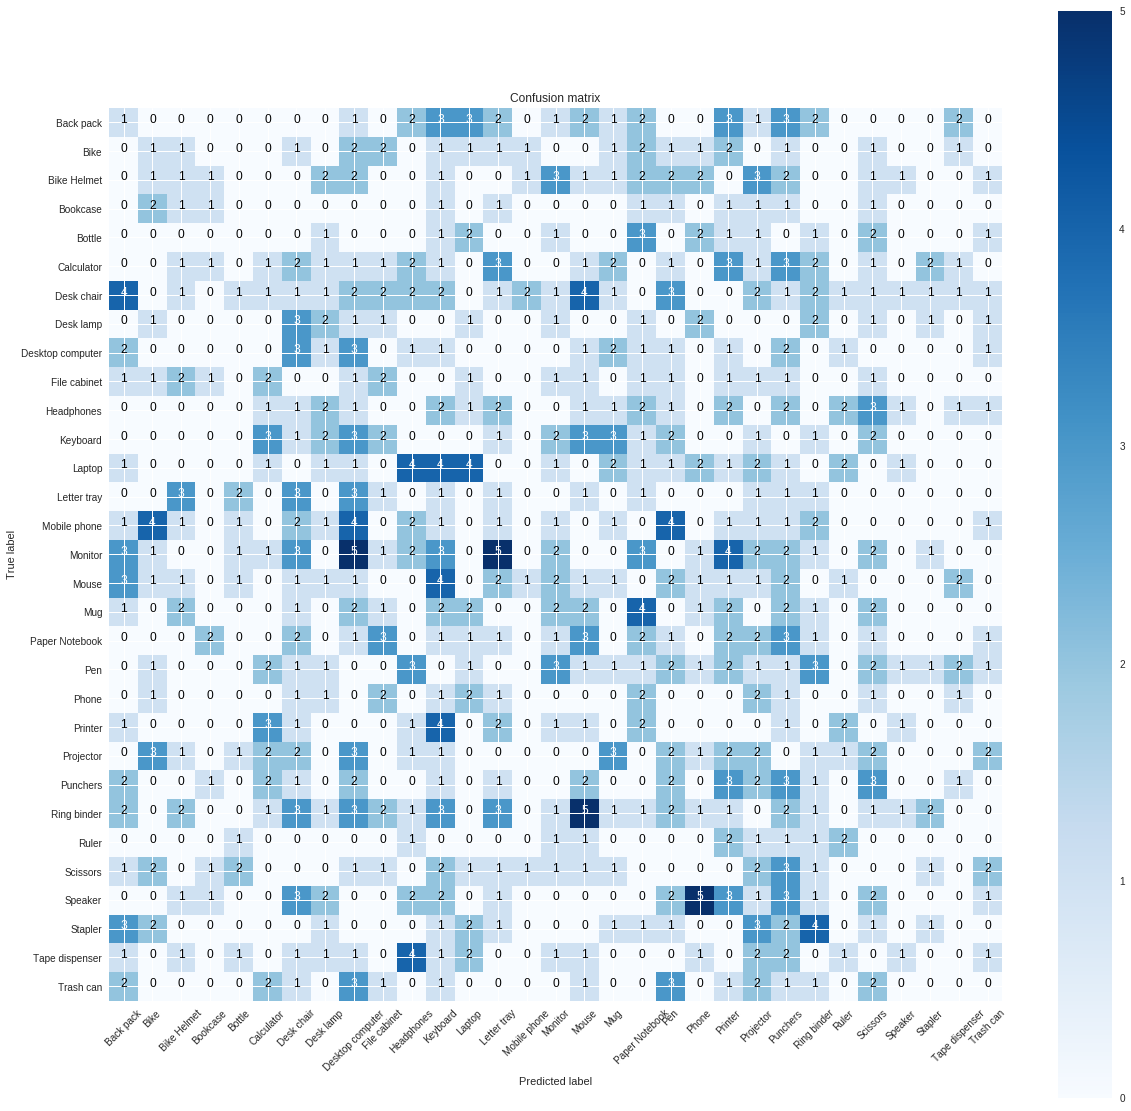

In [35]:
plot_confusion_matrix(cnf, classes=target_names, title='Confusion matrix')

In [36]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

       Back pack       0.03      0.03      0.03        29
            Bike       0.05      0.05      0.05        21
     Bike Helmet       0.05      0.04      0.04        28
        Bookcase       0.11      0.08      0.10        12
          Bottle       0.00      0.00      0.00        16
      Calculator       0.05      0.03      0.04        31
      Desk chair       0.03      0.03      0.03        40
       Desk lamp       0.09      0.11      0.10        18
Desktop computer       0.06      0.14      0.09        21
    File cabinet       0.09      0.11      0.10        19
      Headphones       0.00      0.00      0.00        27
        Keyboard       0.00      0.00      0.00        27
          Laptop       0.17      0.13      0.15        30
     Letter tray       0.03      0.05      0.04        19
    Mobile phone       0.00      0.00      0.00        30
         Monitor       0.07      0.05      0.06  

In [0]:
model.save('inceptionV3.h5')

In [0]:
files.download('inceptionV3.h5')

In [0]:
files.download('checkpoint_inception.h5')